### Data Modeling

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the data
df = pd.read_csv('PG_RESULTS_REDUCED4.csv')
df.head(10)

,index,Birth_Sex,Age,Race,State,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,5341,2,8,8.0,2,2,2,4.0,1.0,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,5342,2,11,3.0,2,1,1,3.0,3.0,1,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,5343,2,5,1.0,2,1,2,3.0,3.0,2,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,5344,1,8,1.0,2,1,1,2.0,3.0,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,5345,2,10,1.0,2,2,1,3.0,1.0,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,5346,2,12,1.0,2,1,1,3.0,1.0,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,5347,2,1,1.0,2,1,2,2.0,3.0,2,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,5348,2,8,1.0,2,1,1,2.0,3.0,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,5349,1,10,1.0,2,2,2,NaN,3.0,2,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,5350,1,9,1.0,2,1,1,2.0,3.0,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [3]:
#Removing the columns State and index as its not needed for Machine Learning and can be utilized for visualizations
df = df.drop(["index","State"], axis=1)
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,2,8,8.0,2,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,2,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,2,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,2,10,1.0,2,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,2,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,2,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,2,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,2,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


from the CDC website document about this dataset, we came to know from the SAS code that
Birth_Sex of 1 = Male and 2 = Female, we will change this to Male - 1 and Female - 0

In [4]:
#Unique values for Sex
df["Birth_Sex"].value_counts()

2    204766
1    173163
Name: Birth_Sex, dtype: int64

In [5]:
df.loc[df["Birth_Sex"] == 2, "Birth_Sex"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,2,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,2,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,2,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


As per the CDC website, the Age for this column was categorized as below
when "Age"=1 then '18-24'
when "Age"=2 then '25-29'
when "Age"=3 then '30-34'
when "Age"=4 then '35-39'
when "Age"=5 then '40-44'
when "Age"=6 then '45-49'
when "Age"=7 then '50-54'
when "Age"=8 then '55-59'
when "Age"=9 then '60-64'
when "Age"=10 then '65-69'
when "Age"=11 then '70-74'
when "Age"=12 then '75-79'
when "Age"=13 then '80-84'
when "Age"=14 then 'NaN' -- missing

In [6]:
#Unique values for Age
df["Age"].value_counts()

10    39309
9     38972
11    35889
8     34259
7     29290
13    28842
6     24912
12    24832
5     24252
1     24235
4     24005
3     22002
2     19676
14     7454
Name: Age, dtype: int64

Looks like we have Age value 14 which were rows with missing values. Instead of dropping those rows, we will try to create 13 bunches of each value and add to the respective bins.

In [7]:
# Split Age column with value 14 into 13 bunches and update them with 1, to 13 to insert no bias to the model

idx = df['Age'].index[df['Age']==14]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//13
second_nan = 2* first_nan
third_nan = 3* first_nan
fourth_nan = 4* first_nan
fifth_nan = 5* first_nan
sixth_nan = 6* first_nan
seventh_nan = 7* first_nan
eigth_nan = 8* first_nan
ninth_nan = 9* first_nan
tenth_nan = 10* first_nan
eleventh_nan = 11* first_nan
twelveth_nan = 12* first_nan

df.loc[idx[0:first_nan], 'Age'] = 1
df.loc[idx[first_nan:second_nan], 'Age'] = 2
df.loc[idx[second_nan:third_nan], 'Age'] = 3
df.loc[idx[third_nan:fourth_nan], 'Age'] = 4
df.loc[idx[fourth_nan:fifth_nan], 'Age'] = 5
df.loc[idx[fifth_nan:sixth_nan], 'Age'] = 6
df.loc[idx[sixth_nan:seventh_nan], 'Age'] = 7
df.loc[idx[seventh_nan:eigth_nan], 'Age'] = 8
df.loc[idx[eigth_nan:ninth_nan], 'Age'] = 9
df.loc[idx[ninth_nan:tenth_nan], 'Age'] = 10
df.loc[idx[tenth_nan:eleventh_nan], 'Age'] = 11
df.loc[idx[eleventh_nan:twelveth_nan], 'Age'] = 12
df.loc[idx[twelveth_nan:total_nan_len], 'Age'] = 13
df.head(10)

7454


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,2,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,2,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,2,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [8]:
df["Age"].value_counts()

10    39882
9     39545
11    36462
8     34832
7     29863
13    29420
6     25485
12    25405
5     24825
1     24808
4     24578
3     22575
2     20249
Name: Age, dtype: int64

--We know the following RACE from CDC website SAS code
when "Race"=1 then 'White'
when "Race"=2 then 'Black'
when "Race"=3 then 'American Indian/Alaskan Native'
when "Race"=4 then 'Asian'
when "Race"=5 then 'Native Hawaiian or other Pacific Islander only, Non-Hispanic'
when "Race"=6 then 'Other Race Only, Non-Hispanic'
when "Race" = 7 then 'Multiracial, Non-Hispanic'
when "Race"=8 then 'Hispanic'
when "Race"=9 then missing values , equivalent to NaN

In [9]:
# Unique values for Race
df["Race"].value_counts()

1.0    281929
8.0     31924
2.0     27054
4.0      9657
9.0      8056
7.0      7840
3.0      6433
6.0      3072
5.0      1963
Name: Race, dtype: int64

As we see the dataset contains the value 9 which is equivalent to NaN, we will try to modify these 8056 Races with derived values to each of the other valid Races

In [10]:
# Split Race column with value 9 into 8 bunches and update them with 1, to 8 to insert no bias to the model

idx = df['Race'].index[df['Race']==9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//9
second_nan = 2* first_nan
third_nan = 3* first_nan
fourth_nan = 4* first_nan
fifth_nan = 5* first_nan
sixth_nan = 6* first_nan
seventh_nan = 7* first_nan

df.loc[idx[0:first_nan], 'Race'] = 1
df.loc[idx[first_nan:second_nan], 'Race'] = 2
df.loc[idx[second_nan:third_nan], 'Race'] = 3
df.loc[idx[third_nan:fourth_nan], 'Race'] = 4
df.loc[idx[fourth_nan:fifth_nan], 'Race'] = 5
df.loc[idx[fifth_nan:sixth_nan], 'Race'] = 6
df.loc[idx[sixth_nan:seventh_nan], 'Race'] = 7
df.loc[idx[seventh_nan:total_nan_len], 'Race'] = 8

df.head(10)

8056


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,2,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,2,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,2,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [11]:
# Unique values for Race
df["Race"].value_counts()

1.0    282824
8.0     33715
2.0     27949
4.0     10552
7.0      8735
3.0      7328
6.0      3967
5.0      2858
Name: Race, dtype: int64

From the CDC website the SAS code for OVERALL_HEALTH says 
when "Overall_Health" = 1 then 'BETTER/GOOD'
when "Overall_Health" = 2 then 'FAIR/POOR'
when "Overall_Health"= 9 then Missing values
So basically we can change 1 and 2 to 1 and 0 and instead of dropping the 9 rows, we can divide them equally into 1 and 0


In [12]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    321531
2     55656
9       742
Name: Overall_Health, dtype: int64

In [13]:
df.loc[df["Overall_Health"] == 2, "Overall_Health"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [14]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    321531
0     55656
9       742
Name: Overall_Health, dtype: int64

In [15]:
# Split Overall_Health 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Overall_Health'].index[df['Overall_Health']== 9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Overall_Health'] = 1
df.loc[idx[first_nan:total_nan_len], 'Overall_Health'] = 0
df.head(10)

742


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [16]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    321902
0     56027
Name: Overall_Health, dtype: int64

From CDC website, we know for PHYSICAL_HEALTH we have 
when "Physical_Health"=1 then it means Zero days when physical health not good
when "Physical_Health"=2 then it means 1-13 days when physical health not good
when "Physical_Health"=3 then it means 14+ days when physical health not good
when "Physical_Health"=9 then it means Don’t know/ Refused/ Missing

In [17]:
# Unique values for Physical_Health
df["Physical_Health"].value_counts()

1    263754
2     67458
3     39302
9      7415
Name: Physical_Health, dtype: int64

In [18]:
# Split Overall_Health 9 into 3 bunches and update them with 1, 2, 3 to insert no bias to the model
idx = df['Physical_Health'].index[df['Physical_Health']== 9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//3
second_nan = 2* first_nan

df.loc[idx[0:first_nan], 'Physical_Health'] = 1
df.loc[idx[first_nan:second_nan], 'Physical_Health'] = 2
df.loc[idx[second_nan:total_nan_len], 'Physical_Health'] = 3
df.head(10)

7415


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.0,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.0,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,NaN,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [19]:
# Unique values for Physical_Health
df["Physical_Health"].value_counts()

1    266225
2     69929
3     41775
Name: Physical_Health, dtype: int64

BMI values can be in various number as each person's BMI will be different. 
Lets check if there are any missing ones. And if there are , let's have them filled in with the mean value of that column

In [20]:
df["BMI_CDC_Categories"].isnull().sum()

38030

In [21]:
# get mean of values in column S2
mean_bmi = df['BMI_CDC_Categories'].mean()
print('Mean of values in column BMI_CDC_Categories:')
print(mean_bmi)

Mean of values in column BMI_CDC_Categories:
2.9775021403416897


In [22]:
# Replace NaNs in column BMI_CDC_Categories with the
# mean of values in the same column
df['BMI_CDC_Categories'].fillna(value=df['BMI_CDC_Categories'].mean(), inplace=True)
print('Updated Dataframe:')
df.head(10)

Updated Dataframe:


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,2.977502,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


From the CDC website we know that for Diabetes
when "Diabetes"=1 then 'Yes'
when "Diabetes"=2 then 'Yes, but only Gestational Diabetes'
when "Diabetes" =3 then 'No'
when "Diabetes"=4 then 'Borderline Diabetes'
when "Diabetes"=7 then 'NaN'
when "Diabetes"=9 then 'refused to answer

In [23]:
# Unique values for Diabetes
df["Diabetes"].value_counts()

3.0    318439
1.0     47852
4.0      8025
2.0      3159
7.0       375
9.0        78
Name: Diabetes, dtype: int64

So we see that there are 7 and 9 values which is equivalent to null/NaNs which we can spread them accross other values instead of deleting those rows

In [24]:
# Split Diabetes column with value 7/9 into 4 bunches and update them with 1 to 4 to insert no bias to the model

idx = df['Diabetes'].index[(df['Diabetes']==7) | (df['Diabetes']==9)]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//4
second_nan = 2* first_nan
third_nan = 3* first_nan


df.loc[idx[0:first_nan], 'Diabetes'] = 1
df.loc[idx[first_nan:second_nan], 'Diabetes'] = 2
df.loc[idx[second_nan:third_nan], 'Diabetes'] = 3
df.loc[idx[third_nan:total_nan_len], 'Diabetes'] = 4

df.head(10)

453


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,2.977502,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [25]:
# Unique values for Diabetes
df["Diabetes"].value_counts()

3.0    318552
1.0     47965
4.0      8139
2.0      3272
Name: Diabetes, dtype: int64

From CDC website, we know for Mental_Health we have 
when "Mental_Health"=1 then it means Zero days when physical health not good
when "Mental_Health"=2 then it means 1-13 days when physical health not good
when "Mental_Health"=3 then it means 14+ days when physical health not good
when "Mental_Health"=9 then it means Don’t know/ Refused/ Missing

In [26]:
# Unique values for Mental_Health
df["Mental_Health"].value_counts()

1    240918
2     85428
3     44862
9      6721
Name: Mental_Health, dtype: int64

In [27]:
# Split Mental_Health 9 into 3 bunches and update them with 1, 2, 3 to insert no bias to the model
idx = df['Mental_Health'].index[df['Mental_Health']== 9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//3
second_nan = 2* first_nan

df.loc[idx[0:first_nan], 'Mental_Health'] = 1
df.loc[idx[first_nan:second_nan], 'Mental_Health'] = 2
df.loc[idx[second_nan:total_nan_len], 'Mental_Health'] = 3
df.head(10)

6721


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,2.977502,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [28]:
# Unique values for Mental_Health
df["Mental_Health"].value_counts()

1    243158
2     87668
3     47103
Name: Mental_Health, dtype: int64

From the CDC website we know for Alcohol Usage
when "Alcohol_Usage" = 1 then 'NO'
when "Alcohol_Usage" = 2 then 'YES'
when "Alcohol_Usage" = 9 then 'NaN'
Lets get these values changed from 2 to 0

In [29]:
# Unique values for Alcohol_Usage
df["Alcohol_Usage"].value_counts()

1    327103
9     28042
2     22784
Name: Alcohol_Usage, dtype: int64

In [30]:
df.loc[df["Alcohol_Usage"] == 2, "Alcohol_Usage"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,2.977502,3.0,2,9,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [31]:
# Split Alcohol_Usage 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Alcohol_Usage'].index[df['Alcohol_Usage']== 9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Alcohol_Usage'] = 1
df.loc[idx[first_nan:total_nan_len], 'Alcohol_Usage'] = 0
df.head(10)

28042


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,...,2.0,2,NaN,2,2,1.0,1.0,9,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,9,...,2.0,2,NaN,2,1,1.0,1.0,9,3,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,...,2.0,2,2.0,2,1,1.0,1.0,5,4,7


In [32]:
# Unique values for Alcohol_Usage
df["Alcohol_Usage"].value_counts()

1    341124
0     36805
Name: Alcohol_Usage, dtype: int64

We will delete the following as those need not be used in Machine Learning and can be used in Visualizations
Metropolitan_y_n, 
Urban_Rural, 
Reported_Income, 
Education_Level

In [33]:
df = df.drop("Metropolitan_y_n", axis=1).drop("Urban_Rural", axis=1).drop("Reported_Income", axis=1).drop("Education_Level", axis=1)
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,9,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,7


From the CDC website we know for Tobacco Usage
when "Tobacco_Usage" = 1 then 'NO'
when "Tobacco_Usage" = 2 then 'YES'
when "Tobacco_Usage" = 9 then 'NaN'
Lets get these values changed from 2 to 0

In [34]:
# Unique values for Tobacco_Usage
df["Tobacco_Usage"].value_counts()

1    309635
2     48921
9     19373
Name: Tobacco_Usage, dtype: int64

In [35]:
df.loc[df["Tobacco_Usage"] == 2, "Tobacco_Usage"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,9,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,7


In [36]:
# Split Tobacco_Usage 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Tobacco_Usage'].index[df['Tobacco_Usage']== 9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Tobacco_Usage'] = 1
df.loc[idx[first_nan:total_nan_len], 'Tobacco_Usage'] = 0
df.head(10)

19373


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,7


From the CDC website we know for Asthma_History
case when "Asthma_History"=1 then 'NO'
when "Asthma_History"=2 then 'YES'
when "Asthma_History"=9 then 'NaN'

In [37]:
# Unique values for Asthma_History
df["Asthma_History"].value_counts()

1    326325
2     50664
9       940
Name: Asthma_History, dtype: int64

In [38]:
df.loc[df["Asthma_History"] == 2, "Asthma_History"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,7


In [39]:
# Split Asthma_History 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Asthma_History'].index[df['Asthma_History']== 9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Asthma_History'] = 1
df.loc[idx[first_nan:total_nan_len], 'Asthma_History'] = 0
df.head(10)

940


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,7


In [40]:
# Unique values for Asthma_History
df["Asthma_History"].value_counts()

1    326795
0     51134
Name: Asthma_History, dtype: int64

We know that for Kidney_Disease
when "Kidney_Disease"=1 then 'YES'
when "Kidney_Disease"=2 then 'NO'
when "Kidney_Disease"=7 then 'NaN'
when "Kidney_Disease"=9 then Refused to answer

In [41]:
# Unique values for Kidney_Disease
df["Kidney_Disease"].value_counts()

2.0    363079
1.0     13789
7.0       979
9.0        81
Name: Kidney_Disease, dtype: int64

In [42]:
df.loc[df["Kidney_Disease"] == 2, "Kidney_Disease"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,2,2.0,2,1,7


In [43]:
# Split Kidney_Disease column with value 7/9 into 2 bunches and update them with 1 or 0 to insert no bias to the model

idx = df['Kidney_Disease'].index[(df['Kidney_Disease']==7) | (df['Kidney_Disease']==9)]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Kidney_Disease'] = 1
df.loc[idx[first_nan:total_nan_len], 'Kidney_Disease'] = 0

df.head(10)

1060


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,2,2.0,2,1,7


In [44]:
# Unique values for Kidney_Disease
df["Kidney_Disease"].value_counts()

0.0    363609
1.0     14319
Name: Kidney_Disease, dtype: int64

We know that for Stroke
when "Stroke" = 1 then 'YES'
when "Stroke" = 2 then 'NO'
when "Stroke" = 7 then 'NaN'
when "Stroke" = 9 then refused to answer
end "Stroke",

In [45]:
# Unique values for Stroke
df["Stroke"].value_counts()

2    363039
1     14204
7       657
9        29
Name: Stroke, dtype: int64

In [46]:
df.loc[df["Stroke"] == 2, "Stroke"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,7


In [47]:
# Split Stroke column with value 7/9 into 2 bunches and update them with 1 or 0 to insert no bias to the model

idx = df['Stroke'].index[(df['Stroke']==7) | (df['Stroke']==9)]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Stroke'] = 1
df.loc[idx[first_nan:total_nan_len], 'Stroke'] = 0

df.head(10)

686


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,7


In [48]:
# Unique values for Stroke
df["Stroke"].value_counts()

0    363382
1     14547
Name: Stroke, dtype: int64

We can see from above that Colonscopy column has some NaN values which we will modify to 1, 2, 3 in equal weights

In [49]:
df["Colonoscopy"].value_counts()

1.0    114907
3.0     43008
2.0     10478
Name: Colonoscopy, dtype: int64

In [50]:
# Split Colonscopy NaNs into 3 bunches and update them with 1, 2, 3 to insert no bias to the model
idx = df['Colonoscopy'].index[df['Colonoscopy'].isnull()]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//3
second_nan = 2* first_nan
# fill first 33.3% of 1
df.loc[idx[0:first_nan], 'Colonoscopy'] = 1
# fill middle 33.3% of 2
df.loc[idx[first_nan:second_nan], 'Colonoscopy'] = 2
# fill last 33.3% of 3
df.loc[idx[second_nan:total_nan_len], 'Colonoscopy'] = 3
df.head(10)

209536


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,1.0,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,1.0,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,1.0,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,7


In [51]:
df["Colonoscopy"].value_counts()

1.0    184752
3.0    112854
2.0     80323
Name: Colonoscopy, dtype: int64

CDC website says that for Prior Heart Disease
when "Prior_Heart_Disease" = 1 then 'Yes, Reported Heart Disease'
when "Prior_Heart_Disease" = 2 then 'No, Did Not Report Heart Disease'
So we will change 2 to 0 for no heart disease

In [52]:
df["Prior_Heart_Disease"].value_counts()

2    345899
1     32030
Name: Prior_Heart_Disease, dtype: int64

In [53]:
df.loc[df["Prior_Heart_Disease"] == 2, "Prior_Heart_Disease"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,0,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,1.0,0,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,0,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,0,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,1.0,0,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,1.0,0,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,7


In [54]:
df["Prior_Heart_Disease"].value_counts()

0    345899
1     32030
Name: Prior_Heart_Disease, dtype: int64

In [55]:
df = df.rename(columns={"Prior_Heart_Disease": "Heart_Disease"}, errors="raise")

We know from CDC website that for Physical Activity
when "Physical_Activity" = 1 then 'Yes, Physical Activities'
when "Physical_Activity" = 2 then 'No Physical Activities'
else 'NaN'

In [56]:
df["Physical_Activity"].value_counts()

1    289660
2     87752
9       517
Name: Physical_Activity, dtype: int64

In [57]:
df.loc[df["Physical_Activity"] == 2, "Physical_Activity"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,0,0,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,1.0,0,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,0,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,0,0,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,1.0,0,0,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,1.0,0,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,7


In [58]:
# Split Physical_Activity column with value 7/9 into 2 bunches and update them with 1 or 0 to insert no bias to the model

idx = df['Physical_Activity'].index[df['Physical_Activity']==9]
total_nan_len = len(idx)
print(total_nan_len)
first_nan = total_nan_len//2

df.loc[idx[0:first_nan], 'Physical_Activity'] = 1
df.loc[idx[first_nan:total_nan_len], 'Physical_Activity'] = 0

df.head(10)

517


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,0,0,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,1.0,0,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,0,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,0,0,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,1.0,0,0,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,1.0,0,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,7


In [59]:
df["Physical_Activity"].value_counts()

1    289918
0     88011
Name: Physical_Activity, dtype: int64

In [60]:
df["Avg_Hours_of_Sleep"].value_counts()

8     116383
7     113719
6      78488
5      23057
9      18891
10      9403
4       9315
12      2659
3       2497
2       1018
1        693
11       560
14       284
16       282
15       238
13       129
18       126
20        84
24        51
17        25
22        11
19         7
23         7
21         2
Name: Avg_Hours_of_Sleep, dtype: int64

Lets check if all data are clean

In [61]:
df.isnull().sum()

Birth_Sex             0
Age                   0
Race                  1
Overall_Health        0
Physical_Health       0
BMI_CDC_Categories    0
Diabetes              1
Mental_Health         0
Alcohol_Usage         0
Tobacco_Usage         0
Asthma_History        0
Kidney_Disease        1
Stroke                0
Colonoscopy           0
Heart_Disease         0
Physical_Activity     0
Avg_Hours_of_Sleep    0
dtype: int64

From the above we see that there are only 3 NaN rows, we can delete them.

In [62]:
df.dropna(inplace=True)
df.isnull().sum()

Birth_Sex             0
Age                   0
Race                  0
Overall_Health        0
Physical_Health       0
BMI_CDC_Categories    0
Diabetes              0
Mental_Health         0
Alcohol_Usage         0
Tobacco_Usage         0
Asthma_History        0
Kidney_Disease        0
Stroke                0
Colonoscopy           0
Heart_Disease         0
Physical_Activity     0
Avg_Hours_of_Sleep    0
dtype: int64

Now the dataset looks clean and is ready for modelling

In [63]:
# df["Metropolitan_y_n"].value_counts()

In [64]:
# # Split Metropolitan_y_n NaNs into 2 bunches and update them with 1, 2 to insert no bias to the model
# idx = df['Metropolitan_y_n'].index[df['Metropolitan_y_n'].isnull()]
# total_nan_len = len(idx)
# print(total_nan_len)
# first_nan = total_nan_len//2
# # fill first 50% of 1
# df.loc[idx[0:first_nan], 'Metropolitan_y_n'] = 1

# # fill last 50% of 2
# df.loc[idx[first_nan:total_nan_len], 'Metropolitan_y_n'] = 2
# df.head(10)

In [65]:
# df["Urban_Rural"].value_counts()

In [66]:
# # Split Metropolitan_y_n NaNs into 2 bunches and update them with 1, 2 to insert no bias to the model
# idx = df['Urban_Rural'].index[df['Urban_Rural'].isnull()]
# total_nan_len = len(idx)
# print(total_nan_len)
# first_nan = total_nan_len//2
# # fill first 50% of 1
# df.loc[idx[0:first_nan], 'Urban_Rural'] = 1

# # fill last 50% of 2
# df.loc[idx[first_nan:total_nan_len], 'Urban_Rural'] = 2
# df.head(10)

In [67]:
# df["Urban_Rural"].value_counts()

In [68]:
# df.head(10)

In [69]:
# df.isnull().sum()

In [70]:
# df["Race"].value_counts()

In [71]:
# There is only 1 NaN row, mapping it to 9 which means not sure about Race.
# df['Race'] = df['Race'].fillna(9)

In [72]:
# df.head(10)

In [73]:
# df["Diabetes"].value_counts()

In [74]:
# There is only 1 NaN row, mapping it to 9 which means not sure about Diabetes.
# df['Diabetes'] = df['Diabetes'].fillna(9)

In [75]:
# df["Kidney_Disease"].value_counts()

In [76]:
# There is only 1 NaN row, mapping it to 9 which means not sure about Kidney_Disease.
# df['Kidney_Disease'] = df['Kidney_Disease'].fillna(9)

In [77]:
# df.isnull().sum()

In [78]:
# df.Prior_Heart_Disease.value_counts()

In [79]:
# df.shape

In [80]:
# df.info()

In [81]:
# df.describe()

In [82]:
# df.nunique()

In [83]:
# df.head(10)

In [84]:
# #change categorical-data to numerical-data

# from sklearn.preprocessing import LabelEncoder
# # category_data = ['gender', 'ever_married','work_type','Residence_type','smoking_status']
# category_data = ['HeartDisease','Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','AgeCategory','Race','Diabetic','PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer']

# for data in category_data:
#     df[data] = LabelEncoder().fit_transform(df[data])

In [85]:
#The Dataset After Using LabelEncoder
# df.head()

In [86]:
# category_data

In [87]:
# df.isnull().sum()

In [88]:
#Normalization = 0-1 Range
# There are no categorical values here as we had decoded all the columns from the CDC website SAS code and prepared the dataset values accoridngly

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


In [89]:
df2 = df.copy()
df2.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,0,0,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,1.0,0,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,0,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,0,0,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,1.0,0,0,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,8
8,1,10,1.0,0,2,2.977502,3.0,2,1,1,1,0.0,0,1.0,0,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,0,1,7


In [90]:
y = df2["Heart_Disease"]
X = df2.drop(columns="Heart_Disease")

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [92]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [93]:
X_test.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Physical_Activity,Avg_Hours_of_Sleep
366790,1,12,1.0,1,1,2.0,3.0,2,1,1,1,1.0,0,3.0,1,7
103795,1,1,1.0,1,1,3.0,3.0,2,1,0,1,0.0,0,1.0,1,5
53718,0,9,1.0,1,1,2.0,3.0,1,1,0,1,0.0,0,1.0,1,6
177855,0,5,8.0,1,1,2.0,3.0,1,1,1,1,0.0,0,2.0,0,6
234390,1,2,8.0,1,1,3.0,3.0,2,1,1,1,0.0,0,2.0,1,8


In [94]:
# Creating various classifier instances as a list.

models = [LogisticRegression(), 
          tree.DecisionTreeClassifier(), 
          RandomForestClassifier(n_estimators=50, random_state=1),
          ExtraTreesClassifier(random_state=1, n_estimators=50), 
          ]

# models = [AdaBoostClassifier(random_state=1, n_estimators=50, base_estimator=DecisionTreeClassifier(max_depth=2, random_state=1))]
# models = [LogisticRegression(),tree.DecisionTreeClassifier(),RandomForestClassifier(n_estimators=128, random_state=78)]


compare = pd.DataFrame(columns=["Model", "F1", "Recall", "Accuracy", "Probability", "Prediction"])
# compare = pd.DataFrame({"Model": ["Logistic Regression", "Decision Tree", "Random Forest"]})
acc_list = []

for m in models:
    m.fit(X_train_scaled, y_train)
    y_pred = m.predict(X_test_scaled)
    y_prob = m.predict_proba(X_test_scaled)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    
    compare = compare.append({'Model': m, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
    acc_list.append(acc)
    print(f'Model used: {str(m)}')
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Precission Score: {precision_score(y_test,y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'F1 Score: {f1_score(y_test,y_pred)}')
    print(f'Probability: {y_prob}')
    print(f'Prediction: {y_pred}')
    compare
    print('-------------------------------------', '\n')


Model used: LogisticRegression()
Accuracy Score: 0.9174551766474037
Precission Score: 0.5327360441075121
Recall Score: 0.09792247276412465
F1 Score: 0.16543606206527553
Probability: [[0.78858687 0.21141313]
 [0.98850173 0.01149827]
 [0.95849126 0.04150874]
 ...
 [0.97947658 0.02052342]
 [0.98095787 0.01904213]
 [0.95981239 0.04018761]]
Prediction: [0 0 0 ... 0 0 0]
------------------------------------- 

Model used: DecisionTreeClassifier()
Accuracy Score: 0.8848457907326264
Precission Score: 0.2547634691195795
Recall Score: 0.1964783379782113
F1 Score: 0.22185667286511226
Probability: [[1.         0.        ]
 [1.         0.        ]
 [0.9375     0.0625    ]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [0.96666667 0.03333333]]
Prediction: [0 0 0 ... 0 0 0]
------------------------------------- 

Model used: RandomForestClassifier(n_estimators=50, random_state=1)
Accuracy Score: 0.9073474312567473
Precission Score: 0.35453315290933696
Recall Score: 0.13275905751203446
F1 Sco

In [95]:
compare

,Model,F1,Recall,Accuracy,Probability,Prediction
0,LogisticRegression(),0.165436,0.097922,0.917455,"[[0.7885868677998409, 0.21141313220015906], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DecisionTreeClassifier(),0.221857,0.196478,0.884846,"[[1.0, 0.0], [1.0, 0.0], [0.9375, 0.0625], [1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"(DecisionTreeClassifier(max_features='auto', r...",0.193180,0.132759,0.907347,"[[0.8138095238095238, 0.1861904761904762], [1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"(ExtraTreeClassifier(random_state=1791095845),...",0.196050,0.138966,0.904776,"[[0.8433333333333333, 0.15666666666666665], [1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Lets try Logistic regression with taking away different columns and see the impact in accuracy, recall etc.

In [96]:
def log_regress_iteration(df, drop_col, compare_log):
    df2 = df.copy()
    y = df2["Heart_Disease"]
    
    X = df2.drop(columns=drop_col).drop(columns='Heart_Disease')
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
    
    # Creating a StandardScaler instance.
    scaler = StandardScaler()
    # Fitting the Standard Scaler with the training data.
    X_scaler = scaler.fit(X_train)

    # Scaling the data.
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    # Creating various classifier instances as a list.

    log_model = LogisticRegression()
    


    log_model.fit(X_train_scaled, y_train)
    y_pred = log_model.predict(X_test_scaled)
    y_prob = log_model.predict_proba(X_test_scaled)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred, pos_label='positive', average=None)

    compare_log = compare_log.append({'Model': log_model, 'drop column': drop_col, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
    return compare_log
    print(f'Model used: {str(log_model)}')
    print(f'Drop Column: {drop_col}')
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Precission Score: {precision_score(y_test,y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'F1 Score: {f1_score(y_test,y_pred)}')
    print(f'Probability: {y_prob}')
    print(f'Prediction: {y_pred}')
    compare_log
    print('-------------------------------------', '\n')

In [97]:
df.head()
compare_log = pd.DataFrame(columns=["Model", "drop column", "F1", "Recall", "Accuracy", "Probability", "Prediction"])
birth_sex = log_regress_iteration(df, "Birth_Sex", compare_log)
age = log_regress_iteration(df, "Age", birth_sex)
race = log_regress_iteration(df, "Race", age)
overall_health = log_regress_iteration(df, "Overall_Health", race)
physical_health = log_regress_iteration(df, "Physical_Health", overall_health)
bmi = log_regress_iteration(df, "BMI_CDC_Categories", physical_health)
diabetes = log_regress_iteration(df, "Diabetes", bmi)
mental_Health = log_regress_iteration(df, "Mental_Health", diabetes)
alcohol_Usage = log_regress_iteration(df, "Alcohol_Usage", mental_Health)
tobacco_Usage = log_regress_iteration(df, "Tobacco_Usage", alcohol_Usage)
asthma_History = log_regress_iteration(df, "Asthma_History", tobacco_Usage)
kidney_Disease = log_regress_iteration(df, "Kidney_Disease", asthma_History)
stroke = log_regress_iteration(df, "Stroke", kidney_Disease)
colonoscopy = log_regress_iteration(df, "Colonoscopy", stroke)
physical_Activity = log_regress_iteration(df, "Physical_Activity", colonoscopy)
sleep_time = log_regress_iteration(df, "Avg_Hours_of_Sleep", physical_Activity)

final_df = sleep_time.copy()
final_df

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'bi

,Model,drop column,F1,Recall,Accuracy,Probability,Prediction
0,LogisticRegression(),Birth_Sex,0.143620,"[0.9927934586778768, 0.08348112490499113]",0.916820,"[[0.8549189916063423, 0.14508100839365767], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LogisticRegression(),Age,0.143046,"[0.9937173742319952, 0.08234101849505954]",0.917572,"[[0.8977508954380692, 0.10224910456193083], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,LogisticRegression(),Race,0.164222,"[0.992146717789994, 0.09716240182417026]",0.917371,"[[0.7900631468884106, 0.2099368531115894], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,LogisticRegression(),Overall_Health,0.140551,"[0.9933824548436273, 0.08107423359513555]",0.917159,"[[0.7610035293258829, 0.23899647067411708], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LogisticRegression(),Physical_Health,0.162811,"[0.9921236199011411, 0.09627565239422346]",0.917275,"[[0.7709242500017268, 0.22907574999827324], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,LogisticRegression(),BMI_CDC_Categories,0.164940,"[0.9919734836235968, 0.09779579427413225]",0.917265,"[[0.7688559948865937, 0.23114400511340624], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,LogisticRegression(),Diabetes,0.152132,"[0.9925509308449207, 0.0890549784646567]",0.917064,"[[0.7689789822537959, 0.2310210177462041], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,LogisticRegression(),Mental_Health,0.166007,"[0.9921582667344204, 0.09830250823410185]",0.917476,"[[0.7967738625191091, 0.20322613748089088], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,LogisticRegression(),Alcohol_Usage,0.165008,"[0.992146717789994, 0.09766911578413985]",0.917413,"[[0.7918696796039615, 0.20813032039603857], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,LogisticRegression(),Tobacco_Usage,0.163724,"[0.9920774241234351, 0.09690904484418546]",0.917286,"[[0.7807795829068254, 0.21922041709317466], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [98]:
# from joblib import dump, load

# # Save rf model
# dump(model, 'logreg_model_v1.joblib')


# from sklearn.pipeline import make_pipeline
# # Create pipeline Scaler + RF model
# pipeline = make_pipeline(X_scaler, model)

In [99]:
# import pickle

# # Save label encoders
# dump(le_Smoking, open('le_Smoking.pkl', 'wb'))
# dump(le_AlcoholDrinking, open('le_AlcoholDrinking.pkl', 'wb'))
# dump(le_Stroke, open('le_Stroke.pkl', 'wb'))
# dump(le_Sex, open('le_Sex.pkl', 'wb'))
# dump(le_AgeCategory, open('le_AgeCategory.pkl', 'wb'))
# dump(le_Race, open('le_Race.pkl', 'wb'))
# dump(le_Diabetic, open('le_Diabetic.pkl', 'wb'))
# dump(le_PhysicalActivity, open('le_PhysicalActivity.pkl', 'wb'))
# dump(le_GenHealth, open('le_GenHealth.pkl', 'wb'))
# dump(le_MentalHealth, open('le_MentalHealth.pkl', 'wb'))

# dump(le_Asthma, open('le_Asthma.pkl', 'wb'))
# dump(le_KidneyDisease, open('le_KidneyDisease.pkl', 'wb'))
# dump(le_SkinCancer, open('le_SkinCancer.pkl', 'wb'))
# dump(le_DiffWalking, open('le_DiffWalking.pkl', 'wb'))
# # dump(model, open('le_model.pkl', 'wb'))

In [100]:
# # Save pipeline
# dump(pipeline, 'pipeline_v1.joblib')


In [101]:
import matplotlib.pyplot as plt

In [102]:
acc_lables = [ "Logistic Regression", "DecisionTree","ExtraTree", "RandomForest"]

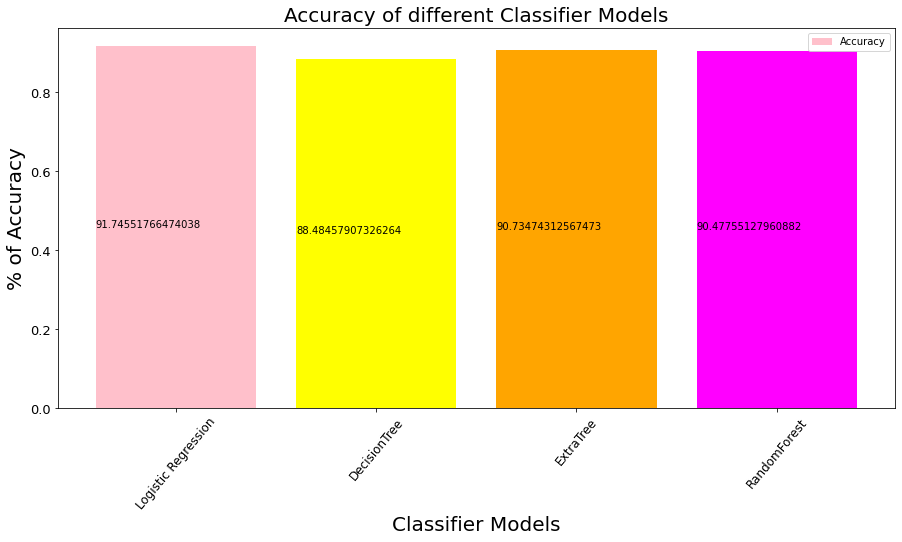

In [103]:
x_axis = acc_lables
y_axis = acc_list
colors = ['pink', 'yellow', 'orange', 'magenta']

# Create the plot
# setting figure size by using figure() function 
plt.figure(figsize = (15, 7))
      
bars = plt.bar(x_axis, y_axis, color=colors, label='Accuracy')
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 50)
plt.yticks(fontsize = 13)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval/2, yval*100)
    
# Add the legend.
plt.legend()
plt.show()